In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("mikoaro/distracteddriver")

print("Path to dataset files:", path)


100%|██████████| 4.01G/4.01G [00:55<00:00, 78.1MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/mikoaro/distracteddriver/versions/1


In [ ]:
import torch
import torch.nn.functional as F
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch import optim
from torch import nn
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data import random_split


In [ ]:
import numpy as np
import pandas as pd
import random
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
warnings.filterwarnings('ignore')

In [ ]:
train_path='/root/.cache/kagglehub/datasets/mikoaro/distracteddriver/versions/1/distracted-driver-detection/train'
test_path='/root/.cache/kagglehub/datasets/mikoaro/distracteddriver/versions/1/distracted-driver-detection/test'

In [ ]:
# Parameters
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 10
TRAIN_DIR = train_path
TEST_DIR = test_path
split_ratio=0.2
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.RandomHorizontalFlip(),  #for increasing diversity
    transforms.RandomRotation(15),
    transforms.ToTensor(),      #converting to tensor data
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

In [ ]:
test_transform = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet normalization
])


In [ ]:
images = datasets.ImageFolder(root=TRAIN_DIR, transform=train_transform)

In [ ]:
images.classes

['c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']

In [ ]:
images.class_to_idx

{'c0': 0,
 'c1': 1,
 'c2': 2,
 'c3': 3,
 'c4': 4,
 'c5': 5,
 'c6': 6,
 'c7': 7,
 'c8': 8,
 'c9': 9}

In [ ]:
type(images)

torchvision.datasets.folder.ImageFolder

In [ ]:
images[0]

(tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          ...,
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
          [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
         [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          ...,
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
          [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
         [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
          [-1.8044, -1.8044,

In [ ]:
len(images)

22424

In [ ]:

num_total = len(images)
num_val = int(split_ratio* num_total)
num_train = num_total - num_val

# Split the dataset into training and validation sets
train_data, test_data = random_split(images, [num_train, num_val])




In [ ]:

print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(test_data)}")

Number of training samples: 17940
Number of validation samples: 4484


In [ ]:
# DataLoaders for training and validation
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
from torchvision import datasets, models, transforms

In [ ]:
# Load pre-trained MobileNetV2
model = models.mobilenet_v2(pretrained=True)

# Modify the classifier to match the number of classes
model.classifier[1] = nn.Linear(model.last_channel, 10)

# Move the model to the device
model = model.to(DEVICE)





In [ ]:
def train_model(model, train_loader, test_loader, epochs=5, learning_rate=0.001):
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        #setting the model to training mode
        model.train()
        #loss of current epoch
        curr_loss = 0
        correct_pred=0
        total_pred=0

        for images, classes in tqdm(train_loader, desc="Training", leave=False):
            #clearing the gradients
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, classes )
            loss.backward()
            optimizer.step()

            curr_loss += loss.item()

            #the maximum value along the label dimension
            value, predicted = torch.max(outputs, 1)
            total_pred += classes .size(0)
            correct_pred += (predicted == classes).sum().item()

        train_accuracy = 100 * correct_pred / total_pred
        avg_loss=curr_loss/len(train_loader)

        print(f'Epoch {epoch+1}, Average Loss: {avg_loss}, Accuracy: {train_accuracy}')

        # evaluation mode
        model.eval()
        #disable grad computation
        with torch.no_grad():

            correct_test_pred=0
            total_test_pred=0
            test_loss = 0

            for images, classes in test_loader:
                outputs = model(images)
                test_loss += criterion(outputs, classes).item()
                value, predicted = torch.max(outputs, 1)
                total_test_pred += classes.size(0)
                correct_test_pred += (predicted == classes).sum().item()

            test_accuracy = 100 * correct_test_pred / total_test_pred

            print(f'Validation Accuracy: {test_accuracy}')

In [ ]:
train_model(model,train_loader,test_loader)

Epoch 1, Average Loss: 0.3328612997526977, Accuracy: 89.38127090301003
Validation Accuracy: 96.07493309545049


Epoch 2, Average Loss: 0.14783094483120582, Accuracy: 95.48494983277592
Validation Accuracy: 96.27564674397858


Epoch 3, Average Loss: 0.12255914300578893, Accuracy: 96.24303232998885
Validation Accuracy: 97.85905441570027


Epoch 4, Average Loss: 0.0979517441033448, Accuracy: 96.99554069119287
Validation Accuracy: 93.7778768956289


Epoch 5, Average Loss: 0.08277901031123391, Accuracy: 97.41360089186176
Validation Accuracy: 95.3835860838537


In [ ]:
# Save the trained model
torch.save(model.state_dict(), 'distracted_driver_model6.pth')


In [ ]:
# Load the model
model.load_state_dict(torch.load('distracted_driver_model6.pth'))
model.eval()

# Predict on a single image
from PIL import Image

def predict(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0).to(DEVICE)  # Add batch dimension
    with torch.no_grad():
        output = model(image)
        _, predicted = torch.max(output, 1)
    return predicted.item()

image_path = '/content/test_image.jpeg'
class_idx = predict(image_path, model, test_transform)
class_name = images.classes[class_idx]
print(f"Predicted Class: {class_name}")


Predicted Class: c1


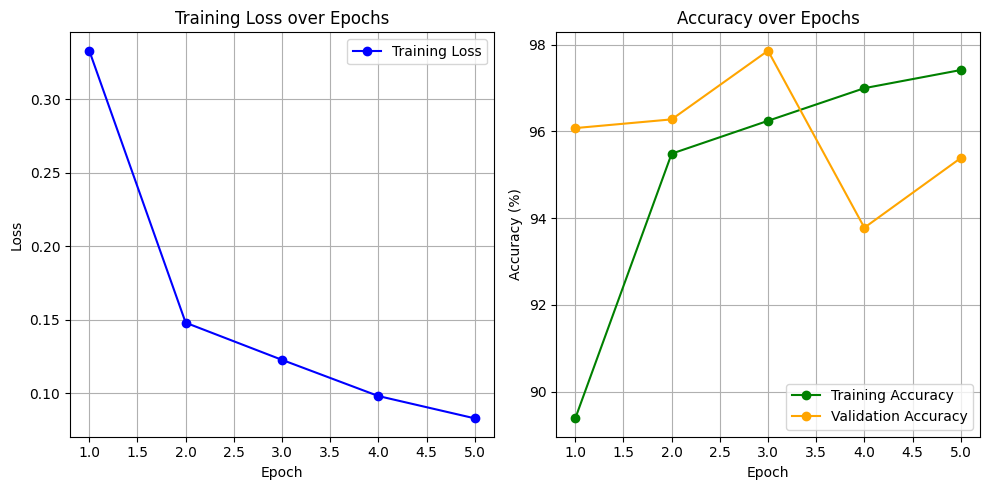

In [ ]:
import matplotlib.pyplot as plt

# Data for plotting
epochs = [1, 2, 3, 4, 5]
train_loss = [0.3328612997526977, 0.14783094483120582, 0.12255914300578893, 0.0979517441033448, 0.08277901031123391]
train_accuracy = [89.38127090301003, 95.48494983277592, 96.24303232998885, 96.99554069119287, 97.41360089186176]
val_accuracy = [96.07493309545049, 96.27564674397858, 97.85905441570027, 93.7778768956289, 95.3835860838537]

# Plot training loss
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, marker='o', label='Training Loss', color='blue')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy, marker='o', label='Training Accuracy', color='green')
plt.plot(epochs, val_accuracy, marker='o', label='Validation Accuracy', color='orange')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
# Load the model
model.load_state_dict(torch.load('distracted_driver_model6.pth'))
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Get predictions on test data
model.eval()
predictions, true_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        predictions.extend(preds.cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Classification report
print(classification_report(true_labels, predictions))




              precision    recall  f1-score   support

           0       0.97      0.96      0.96       472
           1       0.84      1.00      0.91       465
           2       0.94      0.99      0.97       485
           3       0.98      0.99      0.98       476
           4       0.99      0.99      0.99       517
           5       0.99      0.99      0.99       435
           6       0.96      1.00      0.98       449
           7       0.99      0.96      0.98       387
           8       0.98      0.78      0.87       372
           9       0.95      0.87      0.91       426

    accuracy                           0.96      4484
   macro avg       0.96      0.95      0.95      4484
weighted avg       0.96      0.96      0.96      4484



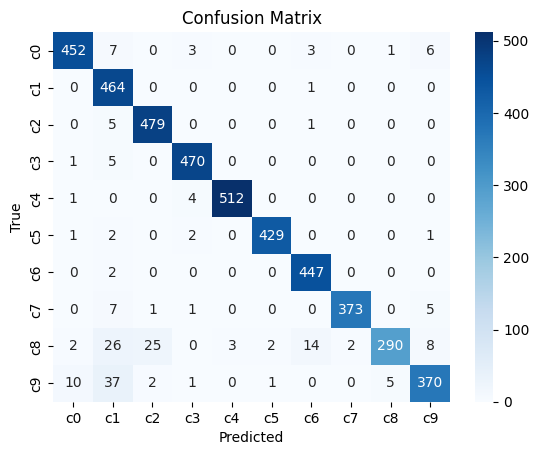

In [ ]:
# Confusion matrix
cm = confusion_matrix(true_labels, predictions)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=images.classes, yticklabels=images.classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()